**Name**: Diran Suraj

**PI**: Z7279378

# TM358 TMA 03 Question 1 - 15 Marks

# Introduction to TMA 03

In this first part of TMA 03, you are researching the use of the GTZAN music classification dataset ([available from Kaggle](https://www.kaggle.com/datasets/achgls/gtzan-music-genre)) for use in the classification of different music genres. 

This database contains measurements of music quality using an MFCC routine. The dataset contains classification of music into different genres. Management feel that using an AI based technique could improve efficiency, by classifying music submissions into different genres.

The dataset consisits on a number of parameters and the type of music. There are 20 sets of MFCC parameters (mfcc_var and mfcc_mean) and 10 types of music classification. You are not required to understand the process of generating this data. The code shows the structure of the dataset.

The analytics department has used an ANN for classification. The team would like you to compare the use of alternative techniques for music classification and to produce a comparison of the performance of the alternative models.

## Completing the TMA

The tasks in this notebook can be addressed using the techniques discussed in Blocks 1 to 5 of the module materials, and the associated notebooks.

You should be able to complete this question when you have completed the practical activities in Block 5.

You should look at the notebooks for Block 3 while working through this question. You will find many useful examples in those notebooks which will help you in this assignment.

Record all your activity and observations in this notebook. Insert additional notebook cells as required. 

Include Markdown cells (like this one) liberally in your solutions, to describe what you are doing. This will help your tutor give full credit for all you have done, and is invaluable in reminding you what you were doing when you return to the TMA after a few days away.

See the VLE for details of how to submit your completed notebook. You should submit only this notebook file for this question.

## Important note about training and saving the model

Ensure that the code cell where you train the model also includes saving of the model and training history. This is a large dataset and models will take some time to train. You can leave the model to train while you do something else (ensure your PC does not go to sleep). 

Once training is finished and the container is idle, it will shut down after a while. If you save the model as soon as it has finished training (in the same notebook cell), you can load the model on your return. If you don't save the model, you will lose that work. 

Below is an example of how to do this.

## Marks are based on process, not results

In this notebook, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluation, not on any particular results you may achieve. **There are no thresholds for accuracy (or any other metric) you must achieve.** You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform. 

## Importing the required libraries

In [1]:
import numpy as np
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Creating some constants

In [2]:
BATCH_SIZE = 1024

## Loading and exploring the data

In [3]:
GENERAL_PATH='/datasets'

In [4]:
filename = os.path.join(GENERAL_PATH, 'features_3_sec_mfcc.csv')
csv_dataset = tf.data.experimental.make_csv_dataset(filename, batch_size=BATCH_SIZE, num_epochs=1).unbatch()
    
dataset = csv_dataset.map(lambda d: (tf.stack([ d['mfcc1_var'],  d['mfcc1_mean'],  d['mfcc2_var'],  d['mfcc2_mean'], 
                                                d['mfcc3_var'],  d['mfcc3_mean'],  d['mfcc4_var'],  d['mfcc4_mean'], 
                                                d['mfcc5_var'],  d['mfcc5_mean'],  d['mfcc6_var'],  d['mfcc6_mean'], 
                                                d['mfcc7_var'],  d['mfcc7_mean'],  d['mfcc8_var'],  d['mfcc8_mean'], 
                                                d['mfcc9_var'],  d['mfcc9_mean'],  d['mfcc10_var'], d['mfcc10_mean'], 
                                                d['mfcc11_var'], d['mfcc11_mean'], d['mfcc12_var'], d['mfcc12_mean'],
                                                d['mfcc13_var'], d['mfcc13_mean'], d['mfcc14_var'], d['mfcc14_mean'], 
                                                d['mfcc15_var'], d['mfcc15_mean'], d['mfcc16_var'], d['mfcc16_mean'], 
                                                d['mfcc17_var'], d['mfcc17_mean'], d['mfcc18_var'], d['mfcc18_mean'], 
                                                d['mfcc19_var'], d['mfcc19_mean'], d['mfcc20_var'], d['mfcc20_mean']]),
                                     tf.one_hot(d['label'], 10)))

## Show the structure of the dataset

In [5]:
dataset.as_numpy_iterator().next()

(array([ 2.16824951e+03, -5.00090218e+01,  6.98829834e+02,  1.01158470e+02,
         9.68515991e+02, -1.00209999e+01,  1.24482246e+02,  4.35189743e+01,
         1.50108109e+02, -1.58563604e+01,  6.99341736e+01,  3.62379684e+01,
         1.12266335e+02, -9.54045236e-01,  3.84905624e+01,  2.91290226e+01,
         4.21609459e+01, -1.25322380e+01,  4.15382500e+01,  1.97684727e+01,
         5.20113564e+01, -3.43805385e+00,  3.71052475e+01,  1.52026234e+01,
         7.29391251e+01, -9.25487041e+00,  3.20205917e+01,  9.60589123e+00,
         5.98047562e+01, -7.45900154e+00,  3.55741501e+01,  4.96353960e+00,
         3.49412346e+01, -7.13662624e+00,  4.47907143e+01,  1.03967266e+01,
         6.66741409e+01,  5.84582710e+00,  1.27085876e+02,  7.95463133e+00],
       dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32))

In [6]:
dataset.as_numpy_iterator().next()[0].shape

(40,)

In [7]:
# Take the elements at index 9, 19, 29... into the validation dataset
test_data = dataset.shard(10, 9)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.cache()

# Create a new train_data dataset. Append the remaining shards of the train_validation_data dataset.
train_data = dataset.shard(10, 8)
for i in range(8):
    train_data = train_data.concatenate(dataset.shard(10, i))

train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.cache()
train_data = train_data.shuffle(5000)

In [8]:
train_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data.as_numpy_iterator().next()

(array([[ 2.5716624e+03, -2.6213326e+01,  6.8504761e+02, ...,
         -2.7304873e+00,  6.3873550e+01,  1.9471998e+00],
        [ 2.8238828e+03, -6.9041840e+01,  6.1599353e+02, ...,
         -1.7058158e+00,  7.7733803e+01, -1.3665002e+01],
        [ 9.4135553e+02, -1.3853113e+02,  1.7356354e+02, ...,
         -4.8139815e+00,  6.8988281e+01, -1.5665220e+00],
        ...,
        [ 3.2235385e+02, -2.9911827e+01,  1.7340591e+02, ...,
          6.4521141e-02,  1.8627453e+01, -2.8704531e+00],
        [ 1.9107386e+03, -2.9030207e+01,  3.7342493e+02, ...,
          1.4019970e+00,  8.1537437e+01,  5.6159086e+00],
        [ 2.9719744e+03, -8.6077843e+01,  7.7716473e+02, ...,
         -2.3284016e+00,  2.4324869e+01,  7.5882757e-01]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dt

# Work Carried out by the Analytics team on the dataset

The following code and results were created by the analytics team. They have created a model, compiled and trained the model using the parameters below.

**Do not change the model structure or training parameters.**

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((40,)),
    tf.keras.layers.Dense(20, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030 (4.02 KB)

 Trainable params: 1,030 (4.02 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(train_data,
    validation_data=test_data,
    epochs=500, verbose=0
         )

I0000 00:00:1742728890.516069      85 service.cc:145] XLA service 0x7f3af4007fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742728890.516122      85 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1742728891.154036      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


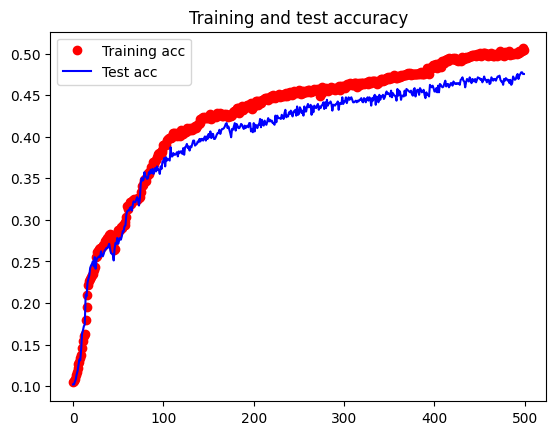

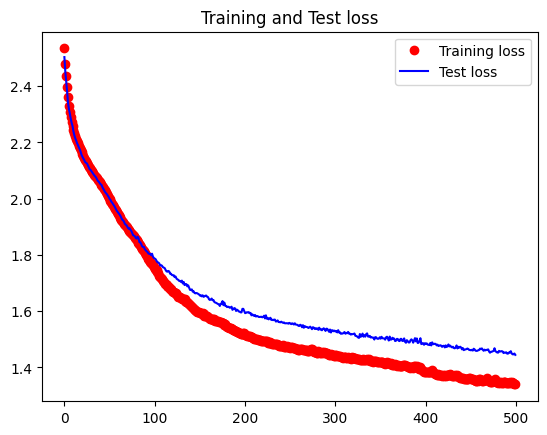

In [13]:
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(train_data, return_dict=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5013 - loss: 1.3412


{'accuracy': 0.5035035014152527, 'loss': 1.33944571018219}

In [15]:
model.evaluate(test_data, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4755 - loss: 1.4446


{'accuracy': 0.4754754900932312, 'loss': 1.4445953369140625}

In [16]:
model.save('analytics_ann_Q1.keras')

In [17]:
model = tf.keras.models.load_model('analytics_ann_Q1.keras')

In [18]:
with open('analytics_ann_Q1.json', 'w') as f:
    json.dump(history.history, f)

In [19]:
with open('analytics_ann_Q1.json') as f:
    example_history = json.load(f)

## This is the end of the code and output produced by the Analytics team

# You are now ready to attempt this question of TMA 03

# Q1 - 15 marks: Investigating alternative methods

The Analytics team have requested that you investigate alternative methods to classify MFCC data for music classification 

The first part your investigation is to train various varieties of decision-tree based models and evaluate their performance.

Firstly, we import and create train and test data.

In [20]:
music_data = np.genfromtxt(os.path.join(GENERAL_PATH, 'features_3_sec_mfcc.csv'), delimiter=',', skip_header=1)

In [21]:
music_data

array([[-1.18627914e+02,  2.44028662e+03,  1.25083626e+02, ...,
        -2.43026793e-01,  4.37717667e+01,  0.00000000e+00],
       [-1.25590706e+02,  2.03834424e+03,  1.22421227e+02, ...,
         5.78406334e+00,  5.99430809e+01,  0.00000000e+00],
       [-1.32441940e+02,  3.79853223e+03,  1.15085175e+02, ...,
         2.51737475e+00,  3.31051216e+01,  0.00000000e+00],
       ...,
       [-2.87840088e+02,  1.80535645e+04,  1.31430176e+02, ...,
        -2.99545288e-01,  4.15869904e+01,  9.00000000e+00],
       [-1.62659592e+02,  3.13110547e+03,  1.05525452e+02, ...,
         6.75824106e-01,  1.27877502e+01,  9.00000000e+00],
       [-2.36018494e+02,  1.98323852e+03,  1.25729851e+02, ...,
        -3.41253424e+00,  3.17274895e+01,  9.00000000e+00]])

In [22]:
X = music_data[:, :-1]
y = music_data[:, -1]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((7492, 40), (7492,), (2498, 40), (2498,))

# Q1(a) Create and adjust Random Forest classifier (4 marks)

Two key parameters for Random Forest classifiers are:

* How many decision trees are in the forest? (controlled by n_estimators)
* How many features from each sample are presented to each tree? (controlled by max_features)

For this question - Produce ONE Random Forest model using the given parameters and ONE improved model. 

Start with the following parameters:

* n_estimators = 5
* max_features = 5

Produce ONE model random forest model using these parameters.

Increase one or both of these parameters to produce ONE improved model.

For each model, print the model's score for the test data and a classification report for the predicted test data.

In [30]:
model_1a_random = RandomForestClassifier(n_estimators=5, max_features=5)

model_1a_random.fit(X_train, y_train)

y_pred = model_1a_random.predict(X_test)

model_1a_random.score(X_test, y_test)

0.5964771817453963

In [31]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.72      0.51      0.59       344
         1.0       0.88      0.75      0.81       284
         2.0       0.45      0.43      0.44       265
         3.0       0.49      0.48      0.49       266
         4.0       0.56      0.58      0.57       234
         5.0       0.58      0.64      0.61       213
         6.0       0.79      0.74      0.76       257
         7.0       0.73      0.70      0.72       258
         8.0       0.52      0.64      0.57       204
         9.0       0.31      0.50      0.38       173

    accuracy                           0.60      2498
   macro avg       0.60      0.60      0.59      2498
weighted avg       0.62      0.60      0.60      2498



The random model with 5 decision trees, each examining 5 features from each sample and is around 60% accuracy for classification. 

In [33]:
model_1a_improved = RandomForestClassifier(n_estimators=20, max_features=20)

model_1a_improved.fit(X_train, y_train)

y_pred = model_1a_improved.predict(X_test)

model_1a_improved.score(X_test, y_test)

0.7594075260208166

In [34]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.76      0.73      0.75       252
         1.0       0.95      0.89      0.92       258
         2.0       0.71      0.65      0.68       279
         3.0       0.70      0.67      0.68       274
         4.0       0.78      0.79      0.79       236
         5.0       0.79      0.77      0.78       244
         6.0       0.89      0.81      0.85       268
         7.0       0.83      0.80      0.82       256
         8.0       0.70      0.76      0.73       235
         9.0       0.52      0.73      0.61       196

    accuracy                           0.76      2498
   macro avg       0.76      0.76      0.76      2498
weighted avg       0.77      0.76      0.76      2498



The improved model has 20 decision trees, each examining 20 features from each sample and is around 75% accuracy for classification.

# Q1b - Create and adjust a bagging classifier  (4 marks)

A bagging classifier isn't a classifier per se, but a way of gathering the "wisdom of crowds" from a group of base estimators. Each base estimator is trained on some fraction of the dataset. Overall predictions of the bag are based on the majority vote of the base estimators.

By default, the sklearn bagging classifier uses a decision tree as a base classifier. num_samples is the fraction of samples to feed to each base estimator; max_features is the fraction of features used by each estimator.

For this question - Produce an initial bagging classifier model using the given parameters and one improved model by adjusting the max_samples and max features.

Start with the following parameters:

* max_samples = 0.2
* max_features = 0.5
* n_estimators = 10

Produce ONE bagging classifier model using these parameters.

Adjust these parameters to produce ONE improved model.

For each model print the model score for the test data and a classification report for the predicted test data.

In [36]:
model_1b_bag = BaggingClassifier(max_samples=0.2, max_features=0.5, n_estimators=10)

model_1b_bag.fit(X_train, y_train)

y_pred = model_1b_bag.predict(X_test)

model_1b_bag.score(X_test, y_test)

0.600880704563651

In [37]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.63      0.48      0.55       319
         1.0       0.93      0.83      0.88       272
         2.0       0.50      0.48      0.49       266
         3.0       0.47      0.49      0.48       251
         4.0       0.57      0.63      0.60       218
         5.0       0.62      0.64      0.63       228
         6.0       0.81      0.69      0.74       286
         7.0       0.75      0.62      0.68       297
         8.0       0.54      0.60      0.57       229
         9.0       0.25      0.53      0.34       132

    accuracy                           0.60      2498
   macro avg       0.61      0.60      0.60      2498
weighted avg       0.63      0.60      0.61      2498



In [38]:
model_1b_improved = BaggingClassifier(max_samples=0.8, max_features=0.9, n_estimators=10)

model_1b_improved.fit(X_train, y_train)

y_pred = model_1b_improved.predict(X_test)

model_1b_improved.score(X_test, y_test)

0.6909527622097679

In [39]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.75      0.61      0.68       296
         1.0       0.94      0.84      0.89       269
         2.0       0.61      0.56      0.58       276
         3.0       0.62      0.61      0.61       265
         4.0       0.66      0.68      0.67       234
         5.0       0.68      0.73      0.70       220
         6.0       0.86      0.79      0.82       265
         7.0       0.79      0.72      0.76       271
         8.0       0.62      0.72      0.66       219
         9.0       0.44      0.66      0.53       183

    accuracy                           0.69      2498
   macro avg       0.70      0.69      0.69      2498
weighted avg       0.71      0.69      0.70      2498



Increasing the max_samples from 0.2 to 0.8 and increasing max_features from 0.5 to 0.9 has increased the test accuracy of the model from 60% to 69%.

# Q1(c) Create and adjust an Ada Boosting Classifier (4 marks)

A boosting classifier has a sequence of classifiers. The first classifier works as normal. The training data for the second classifier is weighted so that it pays more attention to the classes that the first classifier often gets wrong. The next classifier is trained on the data, weighted to account for the errors in the previous classifiers. In this way, the ensemble learns to pay attention to the most difficult cases.

Boosting classifiers can use any sort of classifier at each stage. For this question, you will use a `DecisionTreeClassifier` as the `estimator` in the boosting classifier (following the examples in the Block 5 notebooks).

For this question - Produce an initial Ada boosting classifier model using the given parameters and one improved model by adjusting the `max_depth` and/or `n_estimators`.

Start with the following parameters:

* `max_depth` = 5 (for the `DecisionTreeClassifier`)
* `n_estimators` = 10

Produce ONE boosting classifier model using these parameters.

Adjust these parameters to produce ONE improved model.

For each model print the model score for the test data and a classification report for the predicted test data.

In [51]:
model_1c_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               n_estimators=10)

model_1c_ada.fit(X_train, y_train)

y_pred = model_1c_ada.predict(X_test)

model_1c_ada.score(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.4363490792634107

In [52]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.41      0.45      0.43       221
         1.0       0.66      0.94      0.78       170
         2.0       0.48      0.31      0.38       398
         3.0       0.32      0.28      0.30       298
         4.0       0.38      0.48      0.43       191
         5.0       0.47      0.49      0.48       228
         6.0       0.34      0.70      0.46       117
         7.0       0.45      0.63      0.52       175
         8.0       0.52      0.42      0.46       316
         9.0       0.34      0.25      0.29       384

    accuracy                           0.44      2498
   macro avg       0.44      0.50      0.45      2498
weighted avg       0.43      0.44      0.42      2498



In [53]:
model_1c_ada_improved = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                               n_estimators=20)

model_1c_ada_improved .fit(X_train, y_train)

y_pred = model_1c_ada_improved .predict(X_test)

model_1c_ada_improved .score(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.6609287429943955

In [54]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64       258
         1.0       0.88      0.93      0.91       228
         2.0       0.53      0.58      0.55       233
         3.0       0.55      0.53      0.54       270
         4.0       0.65      0.67      0.66       232
         5.0       0.71      0.73      0.72       229
         6.0       0.81      0.76      0.79       259
         7.0       0.78      0.71      0.74       275
         8.0       0.58      0.61      0.59       242
         9.0       0.50      0.51      0.50       272

    accuracy                           0.66      2498
   macro avg       0.67      0.66      0.66      2498
weighted avg       0.66      0.66      0.66      2498



Increasing the max_depth from 5 to 10 and increasing n_estimators from 10 to 20 has increased the test accuracy of the model from 43% to 66%.

# Q1 (d) Comparison of your model against the ANN model (3 marks)

State the alternative techniques you have used with test data results.
Compare your results with that of the analytics team ANN model.
Recommend a model to use.


> Write your answer here.

From the 3 alternative techniques used with the test data results, I created 3 different models.

For the random forest classifier, the improved model had 20 decision trees, each examining 20 features from each sample and had around 75% accuracy for the classification.

The second model used the bagging classifier and (with max_samples at 0.8 and max_features at 0.9) had an accuracy 69% for its improved model.

Finally, the Ada boosting classifier (with max_depth of 10 and n_estimators at 20) had an accuracy of 66% for its improved model.

Considering the analytics team's ANN model had a test accuracy of 47%, it would appear that each of the alternative techniques had a better accuracy. But out of all 4 models, the random forest classifier was best at 75% accuracy - therefore I recommend the team to use this model.